## Machine Learning

### Time series analysis - predict levels of violence based on previous weeks.
We will attempt to predict levels of violence for upcoming weeks based on data from previous weeks. The production of this data could potentially be automated with a script and displayed on the Nepal Monitor platform alongside current data. Any predictions would likely need to have interpretable metrics and be displayed with a confidence score for purposes of accountability

### Data Preparation:

In [1]:
#list available files in directory
print('Raw Files:')
! ls Data
print('\nProcessed Files:')
! ls Data/output/

Raw Files:
1519759656_39328483.csv
2017 PMP Data Final No Duplicates.xlsx
Federal_VDC_Relation_web_clean.xlsx
Federal_VDC_Relation_web.xlsx
nepalmonitor-reports.csv
nepalmonitor-reports_old.csv
nepal_population_household_ward-2011.csv
NM_2016_17export.csv
npl_polbanda_adm5_wad_25k_50k_sdn_wgs84.csv
output

Processed Files:
District_Province_Population  pop_incidents_VDC.csv
NM_2016_17clean.csv	      sources_vdc.csv


In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

#set up a custom qualitative color palette
xkcd_colors = ['purple','green','blue','pink','brown','red','light blue',\
              'tan','light green','magenta','yellow','sky blue','teal','orange','light purple']
catpal = sns.xkcd_palette(xkcd_colors)


#Import Primary Data Frames
cleanpath='Data/output/NM_2016_17clean.csv'#clean 2017 dataset
newpath = 'Data/nepalmonitor-reports.csv'#NM latest export - new site version
df = pd.read_csv(cleanpath)
new_df = pd.read_csv(newpath)

print(df.shape[0],'x',df.shape[1])
print(new_df.shape[0], 'x',new_df.shape[1])

6630 x 68
7027 x 55


Previous data cleaning efforts have focused on export data, from the previous Nepal Monitor platform. As of November 2018 a new version of NepalMonitor has been deployed, with a significantly streamlined export file. Machine Learning will focus on this new file format (new_df). 

In [3]:
#convert 'INCIDENT DATE' column to date time objects
#df.index = pd.to_datetime(df.loc[:,'INCIDENT DATE'])
#df = df.loc['2017',:]

    
new_df.loc[:,'Event Date'] = pd.to_datetime(new_df.loc[:,'Event Date'])
new_df.index = pd.to_datetime(new_df.loc[:,'Event Date'])
#new_df = new_df.loc['2017':'2018',:]# < taken out to have part of the 2017 data

print(df.shape)
print(new_df.shape)
new_df.head()

(6630, 68)
(7027, 55)


,#,Title,Nepali Title,Event Date,Publication Date,Location,Description,Nepali Description,Tags,Latitude,...,Youth raped,Total abducted,Female abducted,Youth abducted,Total damaged buildings,Severely damaged buildings,Total damaged vehicles,Severely damaged vehicles,Election-related cause - primary,Election-related cause - secondary
Event Date,,,,,,,,,,,,,,,,,,,,,
2018-11-30,21473,"Eight-year-old boy abducted, murdered","गोंगबुमा ८ वर्षीय बालकको अपहरणपछि हत्या, झोलाम...",2018-11-30,2018-11-30,"Province 3, Kathmandu",Eight-year-old boy Prayas Kunwar of Birendra-A...,काठमाडौंको गोंगबुमा ८ वर्षीय बालकको अपहरणपछि ह...,Interpersonal Violence,27.742333942136217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-11-28,21471,Rape accused arrested,बलात्कार घटनाका आरोपित गिरफ्तार ।,2018-11-28,2018-11-29,"Province 5, Rupandehi, Sainamaina, Ward 7",Police on Wednesday arrested 28-year-old Kesha...,१५ वर्षीया बालिकालाई बलात्कार गरेको आरोपमा प्र...,GBV\nChildren’s Rights,27.703940606896413,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-11-27,21459,Right activists stage sit-in demanding justice...,नेपालगन्जमा न्यायका लागि धर्ना।,2018-11-27,2018-11-27,"Province 5, Banke, Nepalgunj",Right activists in Nepalgunj have staged a sit...,कञ्चनपुरकी किशोरी निर्मला पन्तका हत्यारालाई का...,GBV,28.062662265656087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-27,21460,Students padlock office of Trichandra College ...,त्रिचन्द्र कलेजमा तालाबन्दी ।,2018-11-27,2018-11-27,"Province 3, Kathmandu, Kathmandu",Students of Tri Chandra College in Kathmandu o...,शुल्क वृद्धि फिर्ता गर्न माग राख्दै आन्दोलनमा ...,Governance,27.71453911602393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-27,21466,Complaint lodged agaist rape accused,बलात्कार घटनाका आरोपितविरूद्ध उजुरी दर्ता,2018-11-27,2018-11-28,"Province 5, Rupandehi, Mayadevi, Ward 1",A rape complaint was filed against 30 years o...,३० वर्षीया महिलालाई बलात्कार गरेको आरोपमा माया...,GBV,27.584842280023107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [4]:
#Drop out unneeded columns - leaving in provinces doesn't seem to break anything
new_drop = ['#','Title','Nepali Title', 'Ward','Publication Date','Event Date',
            'Nepali Description','Tags','Location','Latitude','Longitude']

#train_df = df.dropna(axis=1, how='all')#.sort_index(axis=1)
test_df = new_df.dropna(axis=1, how='all')#.sort_index(axis=1)


#train_df.drop(drop, axis=1, inplace=True)
test_df.drop(new_drop, axis=1, inplace=True)



In [5]:
#Fix minor inconsistencies in export file to facilitate dummy creation

#Some cells include the same cateogry name repeated on a new line. Strip out the second line.
def strip_newline(string):
    if type(string) == str:
        return string.split('\n')[0]#.lower().replace('nonviolent', 'non-violent').strip()
    else:
        return string

#Strip out anything contained in () and make everything lowercase
def strip_paren(string):
    if type(string) == str:
        return string.split('(')[0].lower()#.replace('nonviolent', 'non-violent').replace('noyouth', 'no-youth').strip()
    else:
        return string

#train_df = train_df.applymap(strip_paren)
full_df = test_df.applymap(strip_newline).applymap(strip_paren)

#train_df.append(test_df) < it looks like the variables are coded differently let's just use 1 dataset for now
full_df.loc[:,'Total killed'] = (full_df.loc[:,'Total killed'] == '1').astype(int)



In [6]:
#One-hot encode categorical columns
dummies = ['Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 'Cause - Secondary', 'Actor 1 - Affiliation', 'Actor 1 - Entity', 'Actor 1 - Youth/non-youth', 'Actor 2 - Target', 'Actor 2 - Affiliation','Actor 2 - Youth/non-youth']
#full_df = full_df.applymap(strip_newline)
#incidents_date_train = pd.get_dummies(train_df, columns=dummies, dummy_na=False)#, drop_first=True)
incidents_date_test = pd.get_dummies(full_df, columns=dummies, dummy_na=False)#, drop_first=True)


#strip out blank dummy categories 
for col in dummies:
    badstr = col+'_'
    if badstr in incidents_date_test.columns:
        incidents_date.drop(badstr, inplace=True, axis=1)
        print('dropped useless category:', badstr)
    

in_week = incidents_date_test.resample('W').sum()
in_day = incidents_date_test.resample('D').sum()

#for province aggrigations
in_week_province = incidents_date_test.groupby('Province').resample('W').sum()
#in_week_VDC = incidencts_date_test.groupby()

print(in_week_province.shape)
#print(in_day_province.shape)
in_week_province.loc[('province 3',),:].head()


(702, 320)


,Total killed,Female killed,Youth killed,Total injured,Female injured,Total raped,Female raped,Youth raped,Total abducted,Female abducted,...,Actor 2 - Affiliation_security forces - apf,Actor 2 - Affiliation_security forces - army,Actor 2 - Affiliation_security forces - police,Actor 2 - Affiliation_security forces - security forces,Actor 2 - Affiliation_students,Actor 2 - Affiliation_unclear,Actor 2 - Youth/non-youth_na,Actor 2 - Youth/non-youth_noyouth,Actor 2 - Youth/non-youth_unknown,Actor 2 - Youth/non-youth_youth
Event Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-08,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,1.0
2017-01-15,2.0,0.0,1.0,4.0,3.0,2.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,5.0
2017-01-22,1.0,0.0,0.0,33.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,7.0,1.0,3.0,1.0
2017-01-29,3.0,1.0,2.0,18.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,3.0,1.0,3.0


Above, we have created a separate column for each variable tracked by the project, and given it a 1 if it was marked and a 0 if not (one hot encoding) and aggregated them by day and week.

In [7]:
#function for converting pandas time series dataframe to training set for supervised learning
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
        Pandas DataFrame of series framed for supervised learning.
        https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
#Create a time shifted dataframe of all variables.
def make_timeshift(df, lookback):
    time_shift = series_to_supervised(df, lookback, dropnan=False).fillna(0)
    return time_shift

lookback=1
time_shift_week = make_timeshift(in_week, lookback)
time_shift_day = make_timeshift(in_day, lookback)
time_shift_province = make_timeshift(in_week_province, lookback)
print(time_shift_day.shape)
print(time_shift_week.shape)
test = pd.concat([time_shift_week['Total killed(t-001)'],time_shift_week['Total killed(t)']],axis=1)
print(test[:5])
time_shift_province.head()

(699, 640)
(101, 640)
            Total killed(t-001)  Total killed(t)
Event Date                                      
2017-01-01                  0.0                2
2017-01-08                  2.0                9
2017-01-15                  9.0               11
2017-01-22                 11.0                4
2017-01-29                  4.0                8


Total killed(t-001)  Female killed(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                  0.0                   0.0   
           2017-01-08                  1.0                   0.0   
           2017-01-15                  2.0                   0.0   
           2017-01-22                  0.0                   0.0   
           2017-01-29                  2.0                   0.0   

                       Youth killed(t-001)  Total injured(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                  0.0                   0.0   
           2017-01-08                  0.0                   2.0   
           2017-01-15                  0.0                   4.0   
           2017-01-22                  0.0                   0.0   
           2017-01-29                  0.0                   3.0   

                       Female injured(t-001)  Total raped(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                    0.0                 0.0   
           2017-01-08                    0.0                 0.0   
           2017-01-15                    0.0                 1.0   
           2017-01-22                    0.0                 1.0   
           2017-01-29                    0.0                 1.0   

                       Female raped(t-001)  Youth raped(t-001)  \
Province   Event Date                                            
province 1 2017-01-01                  0.0                 0.0   
           2017-01-08                  0.0                 0.0   
           2017-01-15                  1.0                 1.0   
           2017-01-22                  1.0                 1.0   
           2017-01-29                  1.0                 0.0   

                       Total abducted(t-001)  Female abducted(t-001)  \
Province   Event Date                                                  
province 1 2017-01-01                    0.0                     0.0   
           2017-01-08                    0.0                     0.0   
           2017-01-15                    0.0                     0.0   
           2017-01-22                    0.0                     0.0   
           2017-01-29                    0.0                     0.0   

                                      ...                  \
Province   Event Date                 ...                   
province 1 2017-01-01                 ...                   
           2017-01-08                 ...                   
           2017-01-15                 ...                   
           2017-01-22                 ...                   
           2017-01-29                 ...                   

                       Actor 2 - Affiliation_security forces - apf(t)  \
Province   Event Date                                                   
province 1 2017-01-01                                             0.0   
           2017-01-08                                             0.0   
           2017-01-15                                             0.0   
           2017-01-22                                             0.0   
           2017-01-29                                             0.0   

                       Actor 2 - Affiliation_security forces - army(t)  \
Province   Event Date                                                    
province 1 2017-01-01                                              0.0   
           2017-01-08                                              0.0   
           2017-01-15                                              0.0   
           2017-01-22                                              0.0   
           2017-01-29                                              0.0   

                       Actor 2 - Affiliation_security forces - police(t)  \
Province   Event Date                                                      
province 1 20

The functions above take the aggregated data and "time-shift" it so that can be used for supervised learning. It essentially puts a series of weeks on the same row as a given number of previous weeks represented by the "lookback" variable. The previous weeks will be used as input and the subsequent weeks will be used to train and score predictions based on that output. Next we will need a "holdout" set to evaluate whether the model we train can predict based on data that it hasn't "seen before"

In [9]:
#Create X y - also do the holdhout split 
def create_X_y(df, holdpc=.25):
    holdsize = int(holdpc * len(df.index))
    y = df.loc[:,'Total killed(t)':]#.iloc[:-holdsize,:]
    X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)']#.iloc[:-holdsize,:]
    
    holdout_y = df.loc[:,'Total killed(t)':].iloc[-holdsize:,:]
    holdout_X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)'].iloc[-holdsize:,:]

    return X, y, holdout_X, holdout_y

X_day, y_day, holdout_X_day, holdout_y_day = create_X_y(time_shift_day)

X_week, y_week, holdout_X_week, holdout_y_week = create_X_y(time_shift_week)

X_province, y_province, holdout_X_province, holdout_y_province = create_X_y(time_shift_province)

for x in [X_day, y_day, holdout_X_day, holdout_y_day, X_week, y_week, holdout_X_week, holdout_y_week]:
    print(x.shape)


y_province.head()

(699, 320)
(699, 320)
(174, 320)
(174, 320)
(101, 320)
(101, 320)
(25, 320)
(25, 320)


Total killed(t)  Female killed(t)  Youth killed(t)  \
Province   Event Date                                                       
province 1 2017-01-01              1.0               0.0              0.0   
           2017-01-08              2.0               0.0              0.0   
           2017-01-15              0.0               0.0              0.0   
           2017-01-22              2.0               0.0              0.0   
           2017-01-29              4.0               0.0              2.0   

                       Total injured(t)  Female injured(t)  Total raped(t)  \
Province   Event Date                                                        
province 1 2017-01-01               2.0                0.0             0.0   
           2017-01-08               4.0                0.0             1.0   
           2017-01-15               0.0                0.0             1.0   
           2017-01-22               3.0                0.0             1.0   
           2017-01-29               3.0                0.0             4.0   

                       Female raped(t)  Youth raped(t)  Total abducted(t)  \
Province   Event Date                                                       
province 1 2017-01-01              0.0             0.0                0.0   
           2017-01-08              1.0             1.0                0.0   
           2017-01-15              1.0             1.0                0.0   
           2017-01-22              1.0             0.0                0.0   
           2017-01-29              4.0             2.0                0.0   

                       Female abducted(t)                 ...                  \
Province   Event Date                                     ...                   
province 1 2017-01-01                 0.0                 ...                   
           2017-01-08                 0.0                 ...                   
           2017-01-15                 0.0                 ...                   
           2017-01-22                 0.0                 ...                   
           2017-01-29                 0.0                 ...                   

                       Actor 2 - Affiliation_security forces - apf(t)  \
Province   Event Date                                                   
province 1 2017-01-01                                             0.0   
           2017-01-08                                             0.0   
           2017-01-15                                             0.0   
           2017-01-22                                             0.0   
           2017-01-29                                             0.0   

                       Actor 2 - Affiliation_security forces - army(t)  \
Province   Event Date                                                    
province 1 2017-01-01                                              0.0   
           2017-01-08                                              0.0   
           2017-01-15                                              0.0   
           2017-01-22                                              0.0   
           2017-01-29                                              0.0   

                       Actor 2 - Affiliation_security forces - police(t)  \
Province   Event Date                                                      
province 1 2017-01-01                                                0.0   
           2017-01-08                                                0.0   
           2017-01-15                                                0.0   
           2017-01-22                                                0.0   
           2017-01-29                                                0.0   

                       Actor 2 - Affiliation_security forces - security forces (t)  \
Province   Event Date                                                                
province 1 2017-01-01                                                0.0             
      

When the holdout percentage (holdout_pc) is set to .25 the holdout set represented approximately by the final 6 months of 2018

## Train predictive models:

The following is a core set of functions for training and testing several machine learning models.

Dry Run:


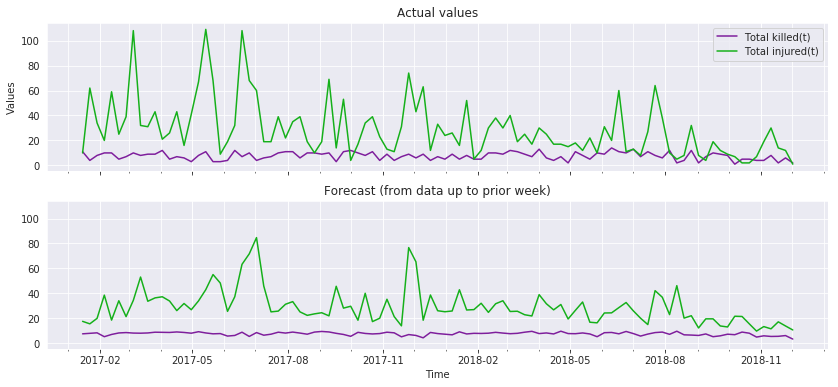

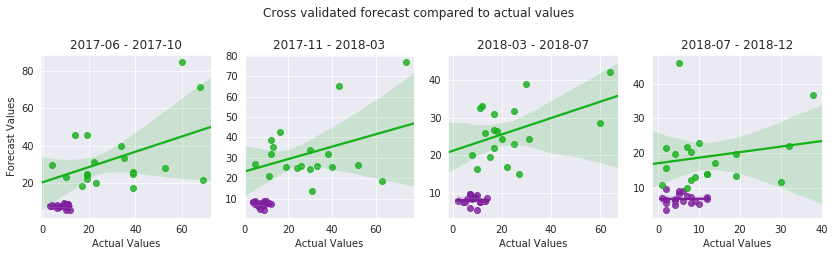

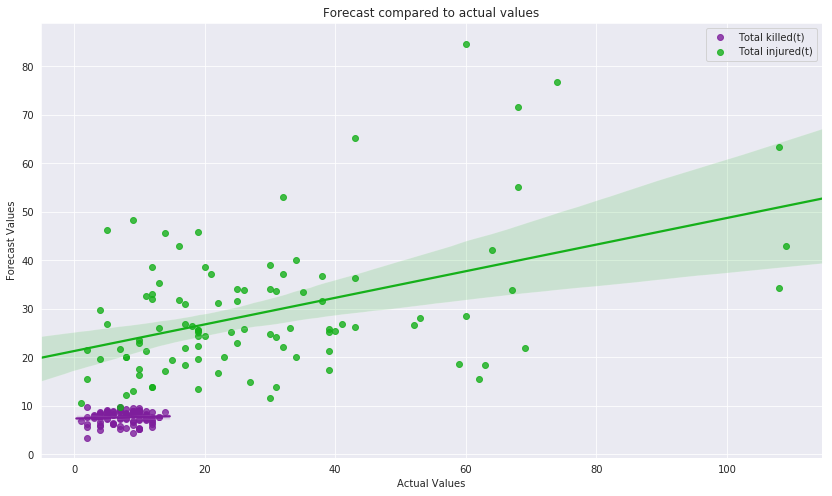

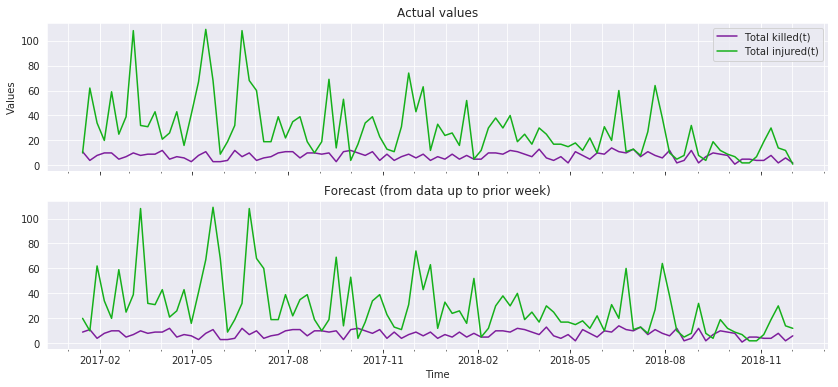

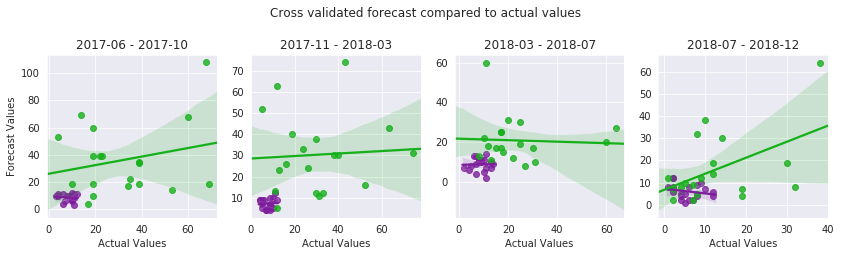

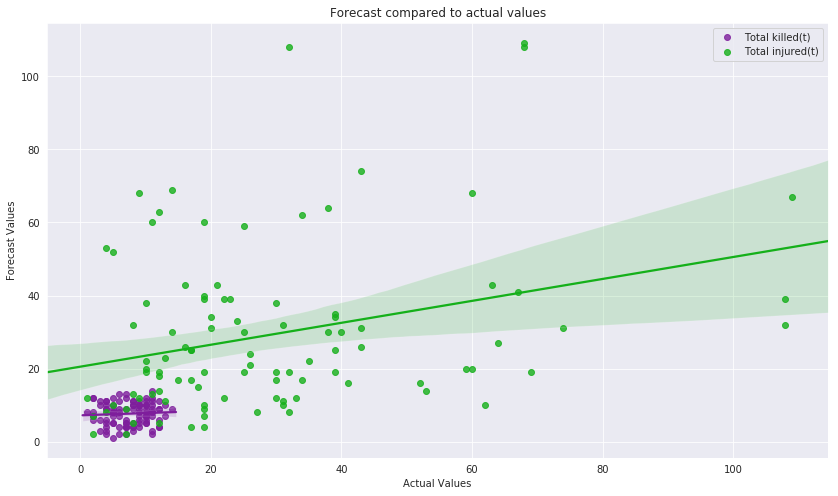

R_2:			 [-0.11192525  0.17204636]
Explained Variance:	 [-0.11166493  0.17215833]
Mean Squared Error:	 [  3.23477007  20.58539985]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.304969          -0.237851                3.063366   
Total injured(t) -0.051781          -0.043046               19.290276   

                       Q2                                             \
                      r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.37345          -0.373430                2.802255   
Total injured(t) -0.09572          -0.077828               18.823096   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.172673          -0.126058                3.352532   
Total injured(t)  0.155066           0.196254               13.587727   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)  -0.277324          -0.191526                3.736590  
Total injured(t) -0.809776          -0.414567               13.887006

In [37]:
#Train and test a given model

#import modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import check_cv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.dates as mdates

#create imputer for nan values - not currently used
imp = Imputer(missing_values='NaN', strategy = 'mean')


def plot_model(y_test, y_pred):
    '''Function to visualize what the model is doing to assist in evaluation'''
    
    months = mdates.MonthLocator()  # every month
    #put the predictions and desired values in a dataframe next to each other
    sync = pd.DataFrame(y_pred, index=y_test.index) #index=y_test.index)
    #print(sync.head())    
    
    #create subplots
    sns.set_style('darkgrid')
    sns.set_palette(catpal)
    
    f, ax = plt.subplots(2,1, figsize=(14,6), sharex=True)
    
    
    #plot the input values
    #ax[0].plot(X_test.sort_index())
    #ax[0].set_title('Test Input (previous weeks)')
    
    #plot the actual values
    ax[0].plot(y_test.sort_index(), )
    ax[0].set_title('Actual values')
    
    
    #plot the predictions
    ax[1].plot(sync.sort_index())
    ax[1].set_title("Forecast (from data up to prior week)")
    
  
    #show the plot
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].set_xlabel('Time')
    ax[0].set_ylabel('Values')
    
    #locs, labels = plt.xticks()
    for x in range(2):
        ax[x].xaxis.set_minor_locator(months)
        ax[x].tick_params(which="both", bottom=True)
        ax[x].grid(which='minor')
    ax[0].legend(labels=y_test.columns)
    plt.show()
    
    #Plot Cross validations
    f, ax = plt.subplots(1,4, figsize=(14,3), sharey=False)
    qsplit = TimeSeriesSplit(n_splits=4)
    frm = '%Y-%m'
    x=0
    for _, test_index in qsplit.split(y_test):
        for var in range(y_test.shape[1]):
            sns.regplot(y_test.iloc[test_index,var], sync.iloc[test_index,var], ax=ax[x], color=catpal[var], label=y_test.columns[var])
        idx = y_test.iloc[test_index,:].index.strftime(frm)
        datestr = str(idx[0]) + ' - ' + str(idx[-1])
        ax[x].set_title(datestr)
        ax[x].set_xlabel('Actual Values')
        ax[x].set_ylabel('')
        x += 1
    
    #show the plot
    f.suptitle('Cross validated forecast compared to actual values', y=1.1)
    ax[0].set_ylabel('Forecast Values')
    plt.show()
    
    #plot a comparison of the actual values next to the predictions - in a seperate figure -
    f, ax = plt.subplots(figsize=(14,8))

    for var in range(y_test.shape[1]):
        sns.regplot(y_test.iloc[:,var], sync.iloc[:,var], ax=ax, label=y_test.columns[var])
    ax.set_title('Forecast compared to actual values')
    ax.set_ylabel('Forecast Values')
    ax.set_xlabel('Actual Values')
    
    if y_test.shape[1] < 15:
        ax.legend(bbox_to_anchor=(1,1))
    
    #show the plot
    plt.show()

def test_model(X_train, X_test, y_train, model):
    '''Function to make predicitons using the model based on training input'''
    #fit the model to the training set
    model.fit(X_train, y_train.values)

    #predict outcomes beased on training set
    y_pred = model.predict(X_test)
    
    #bandaid to set negative predictions to 0
    np.clip(y_pred, a_min=0, a_max=None, out=y_pred)
    
    return y_pred, model #ypred.astype(int, copy=False) < well set all the estimates to whole numbers

def get_coefs(X_train, y_train, model):
    '''get an array of coefficents or feature importances from the model'''
        
    coefs = np.empty((y_train.shape[1], X_train.shape[1]))
    try:
        for n in range(len(model.estimators_)):
            coefs[n] = model.estimators_[n].coef_  #you can get a list of feature names and coefs here in a loop and combine.
    except:
        try:    
            coefs = model.coef_#np.empty(y_pred.shape)
        except:
            try:
                print('unable to fetch coefs, trying importance...')
                coefs = model.feature_importances_
                
            except:
                print('Failed!')
    
    return coefs


def score_model(y_test, y_pred, verbose=False):
    '''fuction to score the model according to several metrics and return those metrics'''
    
    r_2 = r2_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values') #
    ev = explained_variance_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test.astype(float), y_pred.astype(float), multioutput='raw_values'))
       
    if verbose > 0:
        #Plot what these look like with fuction above
        plot_model(y_test, y_pred)
    
    #return train_score, test_score, r_2, ev, rmse, coefs, 
    return r_2, ev, rmse
    
def cv_score(y_test, y_pred):
    '''crossvalidate scores for continuiously trained time series'''
   
    #devine varables for data frames
    qlist = ['Q1','Q2','Q3','Q4']
    vlist = ['r_2','explained_variance','root_mean_squared_error']
    cv = {}
    
    #instantiate time series splitter
    qsplit = TimeSeriesSplit(n_splits=4)
    
    #loop through splits and save scores to dataframe
    x=0
    for _, test_index in qsplit.split(y_test):
        r_2, ev, rmse = score_model(y_test.iloc[test_index], y_pred.iloc[test_index])
        scores = pd.DataFrame(index=y_test.columns, columns=vlist)
        scores.loc[:,'r_2'] = r_2
        scores.loc[:,'explained_variance'] = ev
        scores.loc[:,'root_mean_squared_error'] = rmse
        #save the dataframe in a dictionary
        cv[qlist[x]] = scores 
        x += 1
    
    #concat the dataframes together and return
    cv_df = pd.concat([cv['Q1'],cv['Q2'],cv['Q3'],cv['Q4']], axis=1, keys=cv.keys())#.stack()#, index=y_test.columns)#, columns=midx
    return cv_df




def try_model(X, y, model, verbose=0, random_state=None):
    '''fuction to that takes a given model and a dataset, and evaluates the model
        -gives the option to plot relivant data
        -returns relivant scoring metrics'''

    #Split X and Y into training and testing sets < - try modifying these functions for 'sliding window'
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, shuffle=False, random_state=random_state)
    tscv = TimeSeriesSplit(n_splits=len(y)-1)
    
    
    #idx = 0
    y_pred = pd.DataFrame(index=y.index, columns=y.columns)
    y_control = y_pred.copy(deep=True)
    try:
        warm_start = model.get_params(deep=True)['n_estimators']
    except:
        warm_start = 0
    for train_index, test_index in tscv.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        #if model is using a warm start, set number of parameters based on
        #how many runs we've done, and change training set to a sliding window
        try:
            if model.get_params(deep=True)['warm_start'] == True:
                model.set_params(n_estimators=warm_start) 
                X_train, y_train = X_train[-16:], y_train[-16:]
        except:
            pass
        #use functions above to train model and create predictions_
        y_control.iloc[test_index] = y.iloc[test_index-1].values
        y_pred.iloc[test_index], model = test_model(X_train, X_test, y_train, model)
       
        warm_start+=10
        #debug logging
        
        if test_index.sum() < 0:
            print('\nRun:\t',test_index)
            print('X_train:\t', X_train.iloc[:,:2])
            print('y_train:\t', y_train.iloc[:,:2])
            print('X_test:\t', X_test.iloc[:,:2])
            print('y_pred:\t', y_pred.iloc[test_index])
            print('y_test:\t', y_test.iloc[:,:2])
            print('y_control:\t', y_control.iloc[test_index])
    
    y_test = y #for better plotting
    
    #return train/test split, predicitons and control - with front two datapoints chopped off 
    return X_train[2:], X_test[2:], y_train[2:], y_test[2:], y_pred[2:], y_control[2:].fillna(0) 
    
#define y
y = y_week.loc[:,['Total killed(t)','Total injured(t)']] # > in_week.loc[:,'Total killed'].quantile(.5)      

model = RandomForestRegressor(random_state=56)

print('Dry Run:')
#give the function to try a given model a dry run to see if it works.
X_train, X_test, y_train, y_test, y_pred, y_control = try_model(X_week, y, model, verbose = 2, random_state=56)
dry_scores = score_model(y_test, y_pred, verbose=True)
control_scores = score_model(y_test, y_control, verbose=True)
dry_cv = cv_score(y_test, y_pred)
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')
#for x in ['Q1','Q2','Q3','Q4']:
#    print('\n',x)
#    print(dry_cv[x])
dry_cv

The visualization above is the output of a "dry run" of one model, with a prediction of two variables to ensure the core functions are working correctly. 

Ideally trends in the forecast for a given week or month, should line up with the trends in the actual values for that week. There appears to be a tendency of the forecast to lag behind trends in actual values, but in a few examples of the dry run the peaks and valleys in the trend and the forecast seem to match perfectly. Such as between 2018-04 and 2018-05. This could be the result of random variation, but may also indicate the presence of leading indicators. 

In the scatter plot comparing actual values to forecast values, a line closer to 45 degrees and indicates more of the variation in values are explained in the model, and the more closely the dots are to a given line, the smaller the error is.  These scores are indicated numerically by Root Mean Squared Error (standard deviation of the error), explained variance (how much of the variance in the forecast is explained by the model) and R^2(which is a bit like mix of both).  In a final product on Nepal Monitor, Root Mean Squared Error could be transformed into margin of error or confidence interval to indicate the accuracy of the prediction

Dry Run:


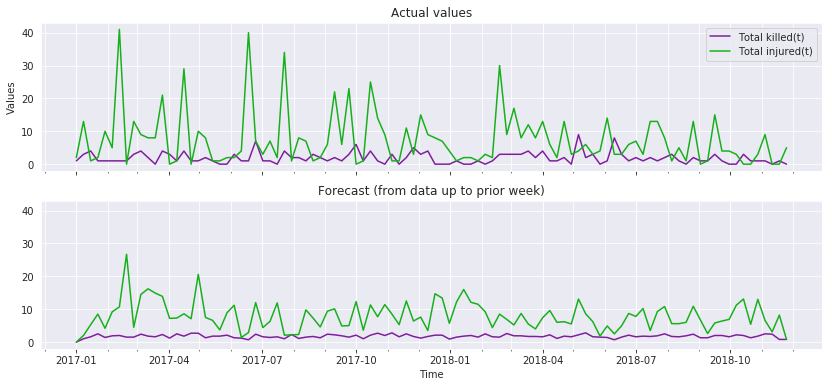

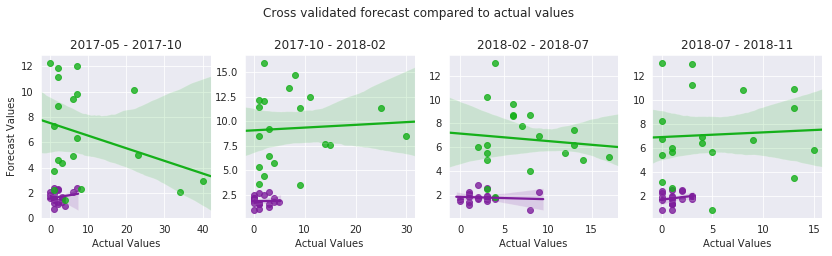

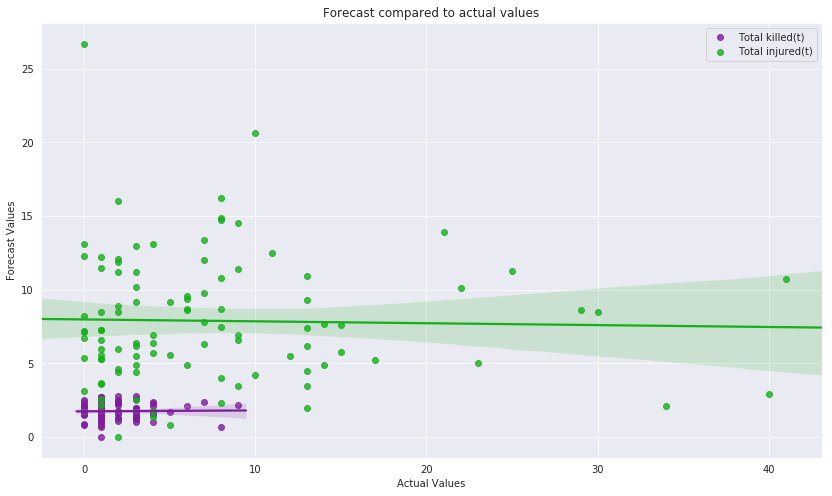

R_2:			 [-0.0831432  -0.29127788]
Explained Variance:	 [-0.080051   -0.28924129]
Mean Squared Error:	 [ 1.79671923  9.54325416]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.008364           0.038245                1.837253   
Total injured(t) -0.347110          -0.306261               13.007056   

                        Q2                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.157998          -0.098292                1.717556   
Total injured(t) -0.202190          -0.150269                8.781657   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.234227          -0.081477                2.515651   
Total injured(t) -0.501299          -0.487236                5.321137   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)  -0.404687          -0.048203                1.161249  
Total injured(t) -0.555082          -0.365781                6.233899

In [23]:
def try_model_province(X, y, model, verbose=0, random_state=None):
    '''fuction to that takes a given model and a dataset, and evaluates the model
        -gives the option to plot relivant data
        -returns relivant scoring metrics'''

    #Split X and Y into training and testing sets < - try modifying these functions for 'sliding window'
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, shuffle=False, random_state=random_state)
   
    
    
    #idx = 0
    y_pred = pd.DataFrame(index=y.index, columns=y.columns)
    y_control = pd.DataFrame(index=y.index, columns=y.columns)#np.empty_like(y) 
    #add loop here to make it iterative by week
   
    warm_start=10
    for week in range(99):
        for pro in range(1,8):
            province = 'province '+str(pro)
            X_prov, y_prov = X.loc[province], y.loc[province] 
            tscv = TimeSeriesSplit(n_splits=int(len(y_prov)-1))
            index = list(tscv.split(X.loc[province])) #change this so it doesn't go all the way through
            train_index, test_index = index[week]
            X_train, X_test = X_prov.iloc[train_index], X_prov.iloc[test_index]
            y_train, y_test = y_prov.iloc[train_index], y_prov.iloc[test_index]
            
            #if model is using a warm start, set number of parameters based on
            #how many runs we've done, and change training set to a sliding window
            try:
                if model.get_params(deep=True)['warm_start'] == True:
                    model.set_params(n_estimators=warm_start) 
                    X_train, y_train = X_train[-16:], y_train[-16:]
            except:
                pass
                
            y_pred.loc[(province,),].iloc[test_index], model\
            = test_model(X_train, X_test, y_train, model)
            #model.fit(X_train.loc[(province,),:], y_train.loc[(province,),:])
            warm_start += 2
            
            #debug logging
            y_control.iloc[test_index] = y.iloc[test_index-1]
            if test_index.sum() < 0:
                print('\nRun:\t',test_index)
                print(province+':')
                print('X_train:\t', X_train.iloc[:,:2])
                print('y_train:\t', y_train.iloc[:,:2])
                print('X_test:\t', X_test.iloc[:,:2])
                print('y_pred:\t', y_pred.loc[province].iloc[test_index])
                print('y_test:\t', y_test.iloc[:,:2])
    
    y_test = y #for better plotting
    
    #return train/test split, predicitons and control - with front two datapoints chopped off 
    return X_train[2:], X_test[2:], y_train[2:], y_test[2:], y_pred[2:], y_control[2:].fillna(0) 

#trying a dry run with provinces
#define y
y = y_province.loc[:,['Total killed(t)','Total injured(t)']] # > in_week.loc[:,'Total killed'].quantile(.5)      

model = RandomForestRegressor(random_state=56, warm_start=False)

print('Dry Run:')
#give the function to try a given model a dry run to see if it works.
X_train, X_test, y_train, y_test, y_pred, y_control = try_model_province(X_province, y, model, verbose = 2, random_state=56)
dry_scores = score_model(y_test.loc['province 2'], y_pred.loc['province 2'].fillna(0), verbose=True)
dry_cv_prov = cv_score(y_test.loc['province 2'], y_pred.loc['province 2'].fillna(0))
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')
#for x in ['Q1','Q2','Q3','Q4']:
#    print('\n',x)
#    print(dry_cv[x])
dry_cv_prov

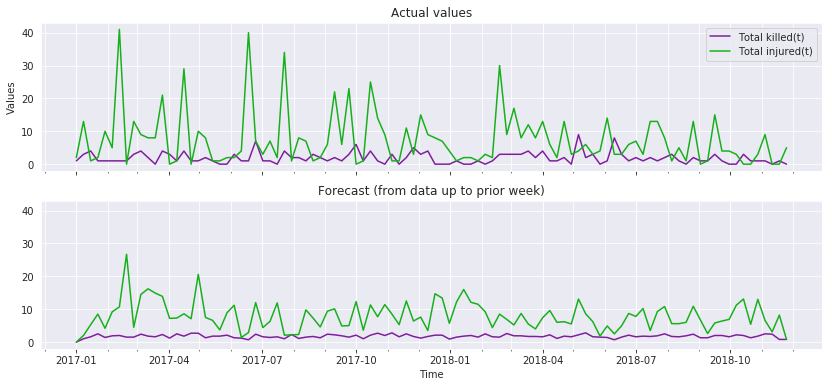

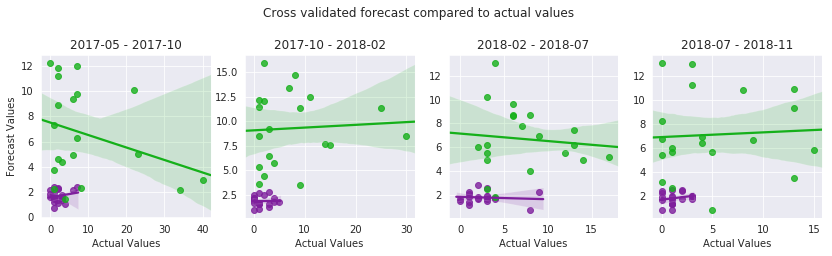

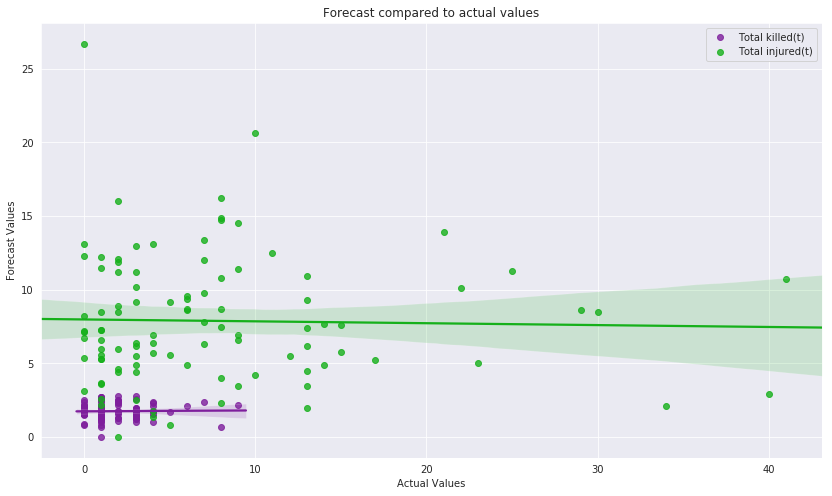

R_2:			 [-0.0831432  -0.29127788]
Explained Variance:	 [-0.080051   -0.28924129]
Mean Squared Error:	 [ 1.79671923  9.54325416]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.008364           0.038245                1.837253   
Total injured(t) -0.347110          -0.306261               13.007056   

                        Q2                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.157998          -0.098292                1.717556   
Total injured(t) -0.202190          -0.150269                8.781657   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.234227          -0.081477                2.515651   
Total injured(t) -0.501299          -0.487236                5.321137   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)  -0.404687          -0.048203                1.161249  
Total injured(t) -0.555082          -0.365781                6.233899

In [12]:
province = 'province 2'
dry_scores = score_model(y_test.loc[province], y_pred.loc[province].fillna(0), verbose=True)
dry_cv_prov = cv_score(y_test.loc[province], y_pred.loc[province].fillna(0))
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')
#for x in ['Q1','Q2','Q3','Q4']:
#    print('\n',x)
#    print(dry_cv[x])
dry_cv_prov

In [13]:
y_test

Total killed(t)  Total injured(t)
Province   Event Date                                   
province 1 2017-01-15              0.0               0.0
           2017-01-22              2.0               3.0
           2017-01-29              4.0               3.0
           2017-02-05              2.0               3.0
           2017-02-12              3.0               5.0
           2017-02-19              0.0               2.0
           2017-02-26              1.0               1.0
           2017-03-05              2.0              45.0
           2017-03-12              0.0               1.0
           2017-03-19              4.0               4.0
           2017-03-26              2.0               0.0
           2017-04-02              1.0               1.0
           2017-04-09              1.0               5.0
           2017-04-16              0.0              11.0
           2017-04-23              2.0               2.0
           2017-04-30              1.0               9.0
           2017-05-07              2.0               7.0
           2017-05-14              3.0               2.0
           2017-05-21              0.0               3.0
           2017-05-28              0.0               2.0
           2017-06-04              1.0               9.0
           2017-06-11              6.0               5.0
           2017-06-18              1.0               1.0
           2017-06-25              2.0               9.0
           2017-07-02              0.0              11.0
           2017-07-09              1.0               5.0
           2017-07-16              2.0               3.0
           2017-07-23              1.0               0.0
           2017-07-30              1.0               2.0
           2017-08-06              2.0               5.0
...                                ...               ...
province 7 2018-05-06              0.0               0.0
           2018-05-13              0.0               1.0
           2018-05-20              0.0               2.0
           2018-05-27              1.0               1.0
           2018-06-03              0.0               0.0
           2018-06-10              0.0               2.0
           2018-06-17              0.0              12.0
           2018-06-24              1.0               0.0
           2018-07-01              2.0               0.0
           2018-07-08              1.0               0.0
           2018-07-15              1.0               4.0
           2018-07-22              2.0               2.0
           2018-07-29              1.0               0.0
           2018-08-05              1.0               1.0
           2018-08-12              0.0               0.0
           2018-08-19              0.0               1.0
           2018-08-26              2.0              12.0
           2018-09-02              0.0               0.0
           2018-09-09              1.0               0.0
           2018-09-16              3.0               0.0
           2018-09-23              2.0               4.0
           2018-09-30              0.0               1.0
           2018-10-07              0.0               2.0
           2018-10-14              0.0               0.0
           2018-10-21              0.0               0.0
           2018-10-28              0.0               0.0
           2018-11-04              0.0               0.0
           2018-11-11              0.0               0.0
           2018-11-18              1.0               0.0
           2018-11-25              0.0               0.0

[700 rows x 2 columns]

In [14]:
y_pred.loc[('province 1',),:]

,Total killed(t),Total injured(t)
Event Date,,
2017-01-15,1.8,3.6
2017-01-22,1.6,3.2
2017-01-29,1.7,3.2
2017-02-05,2.9,2.8
2017-02-12,2.4,2.6
2017-02-19,2,2.9
2017-02-26,1.2,2.3
2017-03-05,2.3,3.7
2017-03-12,1,5.5


### Find variables with the best prediction scores

Finding Variables...

top score r_2: 0.28044605911473
top score explained variance: 0.321124607536
best score rmse: 0.442559132612

control test - forcast using exact values of previous week:
top score r_2: 0.400425267088
top score explained variance: 0.400431029515
best score rmse: 0.550481882563

Top Scoring Variables:


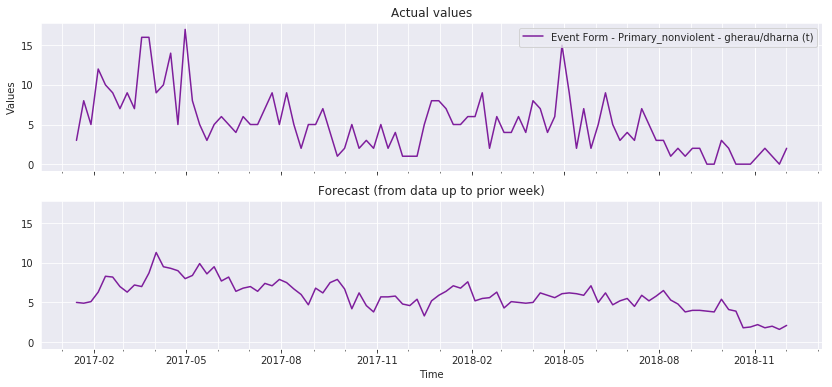

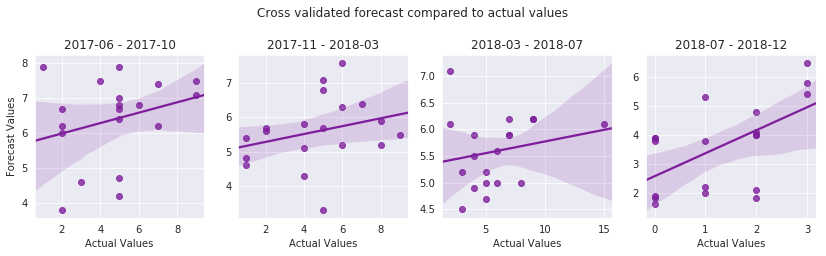

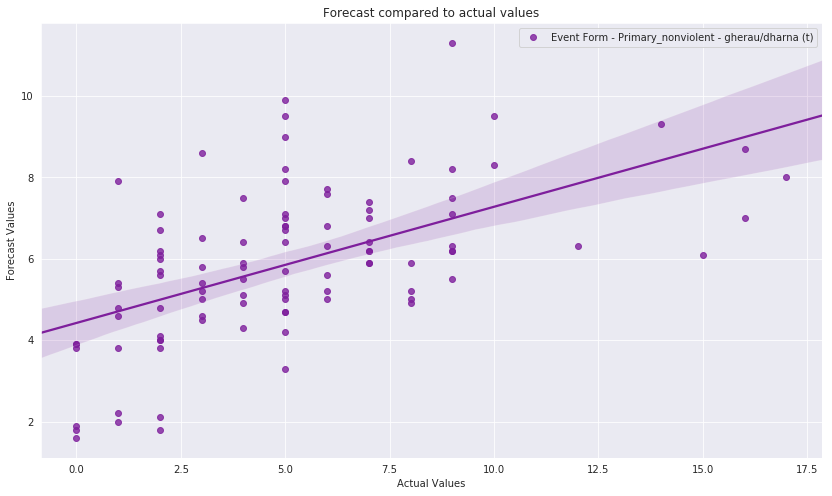

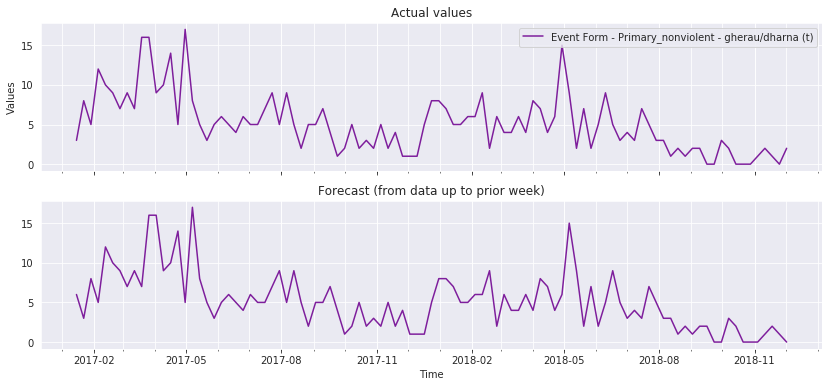

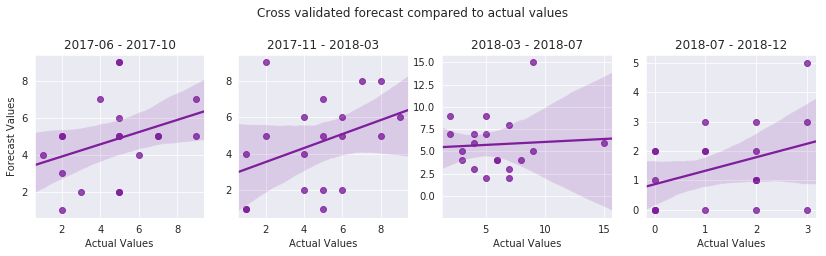

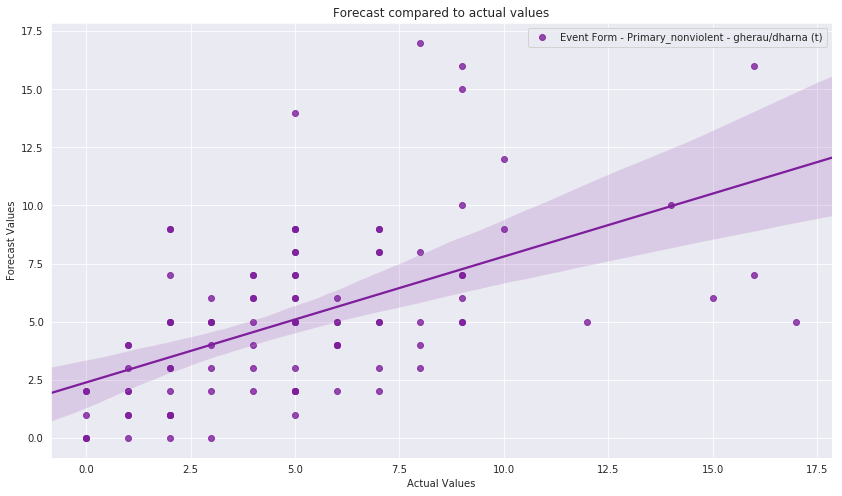

scores  \
                                                         r_2   
Event Form - Primary_nonviolent - gherau/dharna...  0.264228   
Violent / Nonviolent_nonviolent(t)                  0.257469   
Total raped(t)                                       0.20544   
Female raped(t)                                     0.185361   
Actor 1 - Youth/non-youth_noyouth(t)                0.166983   
Actor 1 - Youth/non-youth_unknown(t)                0.166911   
Actor 2 - Youth/non-youth_na(t)                     0.148662   
Collective / Interpersonal_interpersonal(t)         0.130992   
Collective / Interpersonal_collective(t)            0.126759   
Youth raped(t)                                      0.123443   

                                                                       \
                                                   explained_variance   
Event Form - Primary_nonviolent - gherau/dharna...           0.307715   
Violent / Nonviolent_nonviolent(t)                           0.298906   
Total raped(t)                                               0.268435   
Female raped(t)                                               0.24278   
Actor 1 - Youth/non-youth_noyouth(t)                         0.193403   
Actor 1 - Youth/non-youth_unknown(t)                         0.185878   
Actor 2 - Youth/non-youth_na(t)                              0.165639   
Collective / Interpersonal_interpersonal(t)                  0.133906   
Collective / Interpersonal_collective(t)                     0.139678   
Youth raped(t)                                                0.17998   

                                                                            \
                                                   root_mean_squared_error   
Event Form - Primary_nonviolent - gherau/dharna...                 3.13279   
Violent / Nonviolent_nonviolent(t)                                  9.5567   
Total raped(t)                                                     5.19448   
Female raped(t)                                                    5.07164   
Actor 1 - Youth/non-youth_noyouth(t)                                4.2652   
Actor 1 - Youth/non-youth_unknown(t)                               21.5892   
Actor 2 - Youth/non-youth_na(t)                                    16.6307   
Collective / Interpersonal_interpersonal(t)                        8.80879   
Collective / Interpersonal_collective(t)                           25.8849   
Youth raped(t)                                                     4.64549   

                                                   control_scores  \
                                                              r_2   
Event Form - Primary_nonviolent - gherau/dharna...      0.0897701   
Violent / Nonviolent_nonviolent(t)                      0.0941051   
Total raped(t)                                          0.0199168   
Female raped(t)                                         0.0245817   
Actor 1 - Youth/non-youth_noyouth(t)                   -0.0864838   
Actor 1 - Youth/non-youth_unknown(t)                   -0.0422835   
Actor 2 - Youth/non-youth_na(t)                          0.043861   
Collective / Interpersonal_interpersonal(t)             0.0264528   
Collective / Interpersonal_collective(t)               -0.0166692   
Youth raped(t)                                          -0.142222   

                                                                       \
                                                   explained_variance   
Event Form - Primary_nonviolent - gherau/dharna...          0.0898925   
Violent / Nonviolent_nonviolent(t)                          0.0947098   
Total raped(t)                                              0.0199198   
Female raped(t)                                             0.0245849   
Actor 1 - Youth/non-youth_noyouth(t)                       -0.0864792   
Actor 1 - Youth/non-youth_unknown(t)                       -0.0420202   
Actor 2 - Youth/non-youth_na(t)                           

In [15]:
#find which variables have the best scores
from sklearn.linear_model import ARDRegression

def find_var (X, df, model, n_true, verbose=False, random_state=None, s_plot=0, n_plot=1, province=''):
   
    #filter out varables where the perentage "true" is less than n_true, to avoid completely unbalanced data
    pc_true = [sum(df[x] >= 1)/len(df[x])*100 > n_true for x in df.columns]
    y = df.loc[:,pc_true] 
    
    if province != '':  
        X_train, X_test, y_train, y_test, y_pred, y_control = try_model_province(X, y, model, verbose=False)
        y_test = y_test.loc[province].dropna()
        y_pred = y_pred.loc[province].fillna(0)
        y_control = y_control.loc[province].fillna(0)
    
    else:
        X_train, X_test, y_train, y_test, y_pred, y_control = try_model(X, y, model, verbose=False)
 
    #score the model

    r_2, ev, rmse = score_model(y_test, y_pred, verbose=False)
    
    #Score the model based on control (simply continuing the values from the previous week). 
    r_2_c, ev_c, rmse_c, = score_model(y_test, y_control, verbose=False)
    
    #save all these scores in data frames
    collist = ['r_2','explained_variance','root_mean_squared_error']    
    scores = pd.DataFrame(index=df.columns, columns=(collist))
    scores_c = pd.DataFrame(index=df.columns, columns=(collist))
    
    scores.loc[pc_true,'r_2'] = r_2
    scores.loc[pc_true,'explained_variance'] = ev
    scores.loc[pc_true,'root_mean_squared_error'] = rmse

    scores_c.loc[pc_true,'r_2'] = r_2_c
    scores_c.loc[pc_true,'explained_variance'] = ev_c
    scores_c.loc[pc_true,'root_mean_squared_error'] = rmse_c
    
    #crossvalidate quarterly periods
    cv_scores = cv_score(y_test, y_pred)
    
    #calculate cv means
    cv_mean = pd.DataFrame(index=cv_scores.index)
    #cv_mean.set_columns(['cv_mean',collist],inplace=True)
    for x in range(3):
        col = collist[x]
        cv_mean.loc[:,col] = [cv_scores.iloc[y,x::3].agg('mean') for y in range(len(cv_scores))]
    
    if verbose > 1:
        #print scores
        #print('total train score:', train_score )
        #print('total test score:', test_score)
        print('\ntop score r_2:',scores['r_2'].max())
        print('top score explained variance:',ev.max())
        print('best score rmse:',rmse.min()) 
        
        print('\ncontrol test - forcast using exact values of previous week:')
        print('top score r_2:',r_2_c.max())
        print('top score explained variance:',ev_c.max())
        print('best score rmse:',rmse_c.min())
    
    #add crossvalidated scores to dataframe
    
    cv_mean.columns = pd.MultiIndex.from_product([['cv_mean'],collist])
    scores.columns = pd.MultiIndex.from_product([['scores'],collist])
    scores_c.columns = pd.MultiIndex.from_product([['control_scores'],collist])
    
    scores = pd.concat([scores, scores_c, cv_mean, cv_scores], axis=1)    
    #find best crossvalidation scores? - maybe after draft presentation    
    
    #filter out explained variance scores below 
    top = scores.loc[scores[('scores','explained_variance')] > -1].sort_values(('scores','r_2'), ascending=False)
    
    #filter out scores that don't beat the control - (errors are higher than control)
    worse = top.loc[top[('scores','root_mean_squared_error')] > top[('control_scores','root_mean_squared_error')]]
    top.drop(worse.index, inplace=True)
    
    #find differences between model and control in R_2
    diff = (top[('scores','r_2')] - top[('control_scores','r_2')])#.sort_values(ascending=False)
    
    #filter out low differences with control
    top = top.loc[diff > .1]
    
    
    if verbose > 0:
        #plot what the best scores look like. 
        print("\nTop Scoring Variables:")
        yfilt = [ x in top[s_plot:n_plot].index.tolist() for x in y_test.columns]
        plot_model(y_test.loc[:,yfilt], y_pred.loc[:,yfilt])
    
    if verbose > 1:
    #plot what the control scores look like
        #print(y_control)
        plot_model(y_test.loc[:,yfilt], y_control.loc[:,yfilt])
    
    #top_scores = score_model(X_train, X, y_train.loc[:,top.index[:3]], y.loc[:,top.index[:3]], y_pred.loc[:,top.index[:3]], model, verbose=verbose)
    #top_scores = find_var(X_week, y_week.loc[:,better.index[:3]], model, n_true=20, verbose=2, random_state=38)
    return scores, top

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)
#for step in range(5,y_week.shape[1])[::5]:
    #model = MultiOutputRegressor(ARDRegression(), n_jobs=-1)
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    #model = LinearRegression()
    model = RandomForestRegressor(random_state=56, warm_start=False)
    
    print("Finding Variables...")
    scores, top = find_var(X_week, y_week, model, n_true=20, verbose=2, n_plot=1)
    
    #print top 10 scores that beat control
top[:10]
    

The model is doing well when asked to predict everything from everything, loses effectiveness when asked to predict a narrow set of variables.  May have to change how scoring / plot works. Luckily it seems to do significantly better than control (assuming value will be the same as the previous week). Perhaps use classifier to predict increase or decrease is an option.

In [16]:
#Optimize with Gridsearch / random search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#define param grid - get params from model - test first
params = {'n_estimators':range(150,300,1),
          'warm_start':[False],
          'max_depth':range(1,300,1),
          'min_samples_split':np.linspace(0.00000001,.2,100),
          'min_samples_leaf':range(5,6,1),
          'min_weight_fraction_leaf':np.linspace(.0000001,.15,100),
          'max_features':range(150,200,1),
          'max_leaf_nodes':range(180,300,1),
          'min_impurity_decrease':np.linspace(0.000001,.6,100)}

#params = {'n_estimators':range(25,50,1),
#          'max_depth':range(1,300,1),
#          'min_samples_split':np.linspace(0.0001,.2,100),
#          'min_samples_leaf':range(6,7,1),
#          'min_weight_fraction_leaf':np.linspace(0,.1,100),
#          'max_features':range(270,300,1),
#          'max_leaf_nodes':range(10,100,1),
#          'min_impurity_decrease':np.linspace(.2,.6,100)}



#define splitter... time series split?
qsplit = TimeSeriesSplit(n_splits=4)

#instantiate grid search - use normal scoring function
#Search = GridSearchCV(RandomForestRegressor(random_state=56), param_grid=params, cv=qsplit)
Search = RandomizedSearchCV(RandomForestRegressor(random_state=56), param_distributions=params, cv=qsplit, n_jobs=-1, n_iter=100)


#fit X_week, Y_week
Search.fit(X_week, y_week.loc[:,top.index])

#find the best scoring model
best_params = Search.best_params_
best_score = Search.best_score_
#show the results
results = Search.cv_results_
#print('results:\n',results)
print('\nbest parameters',best_params)
print('best score',best_score)
#Next try plotting parameters next to resulting scores


best parameters {'warm_start': False, 'n_estimators': 163, 'min_weight_fraction_leaf': 0.057575819191919189, 'min_samples_split': 0.062626269494949496, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.1939400707070707, 'max_leaf_nodes': 291, 'max_features': 188, 'max_depth': 79}
best score -0.311680195251


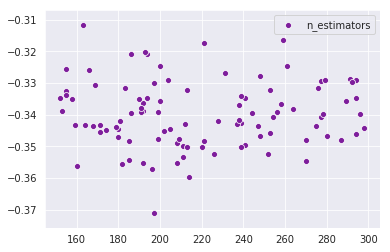

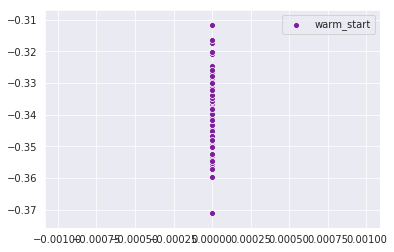

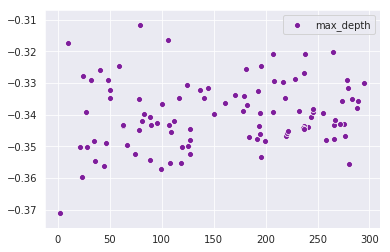

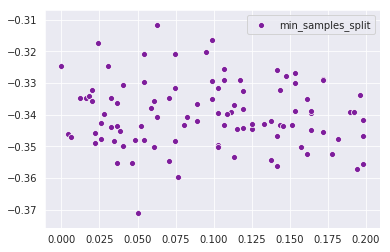

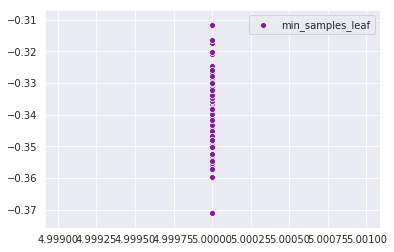

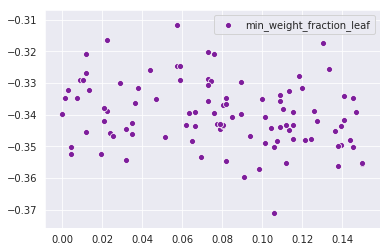

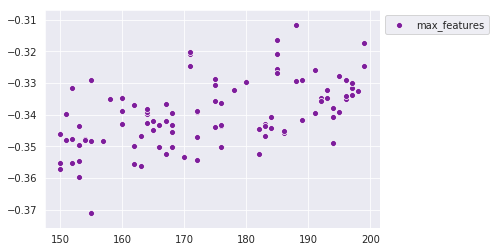

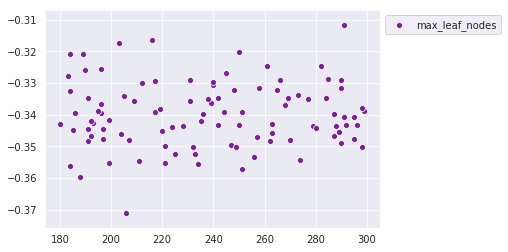

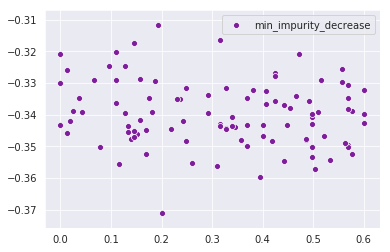

In [17]:
#Plot Results
for key in params.keys():
    sns.scatterplot(results['param_'+key],results['mean_test_score'], label=key)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

Finding Variables...

top score r_2: 0.2981829204782117
top score explained variance: 0.350669426674
best score rmse: 0.41569231181

control test - forcast using exact values of previous week:
top score r_2: 0.400425267088
top score explained variance: 0.400431029515
best score rmse: 0.550481882563

Top Scoring Variables:


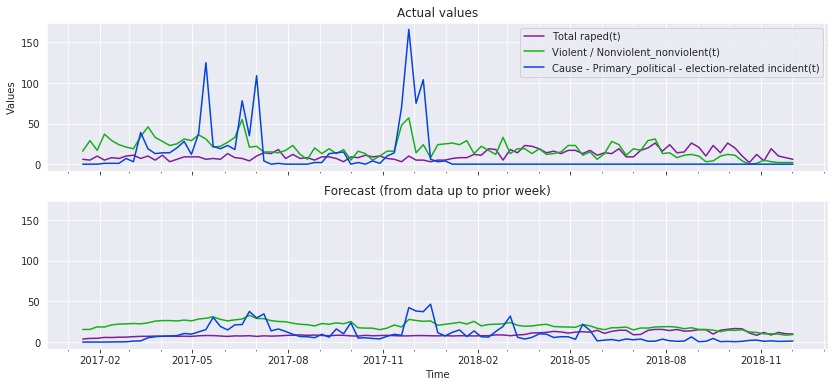

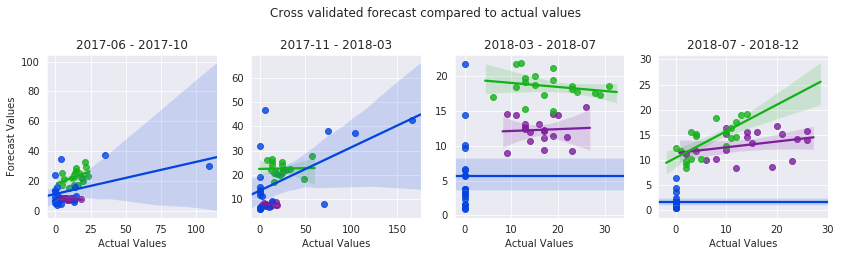

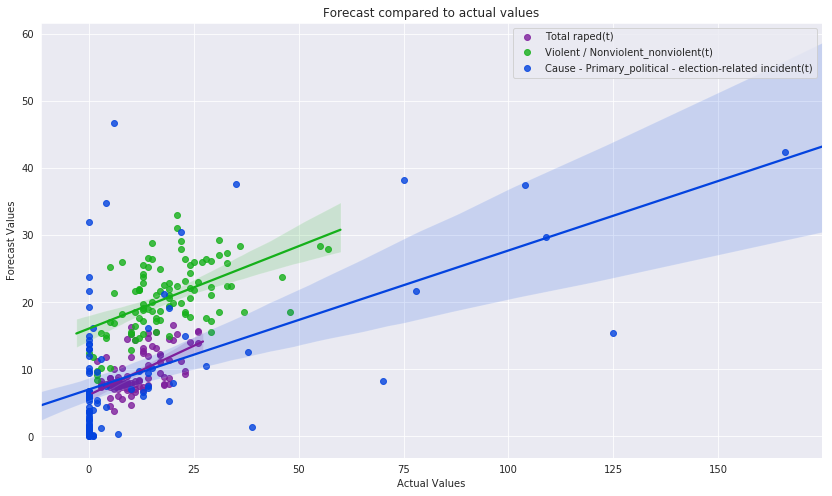

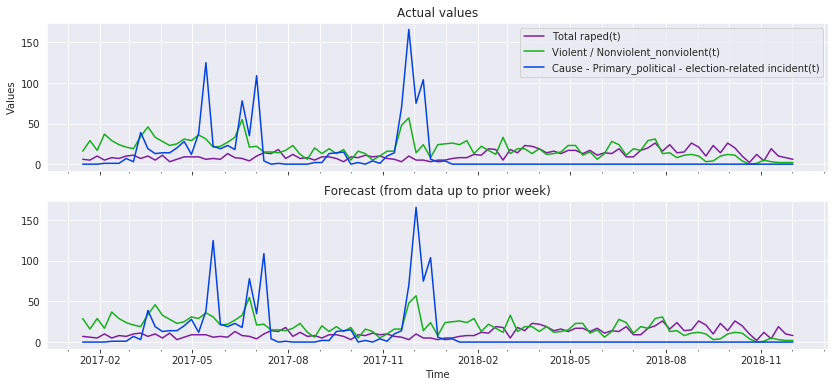

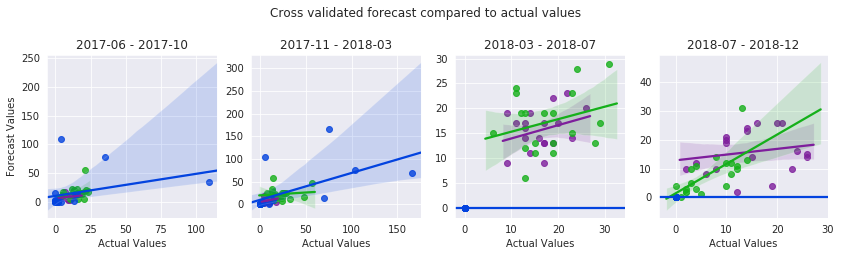

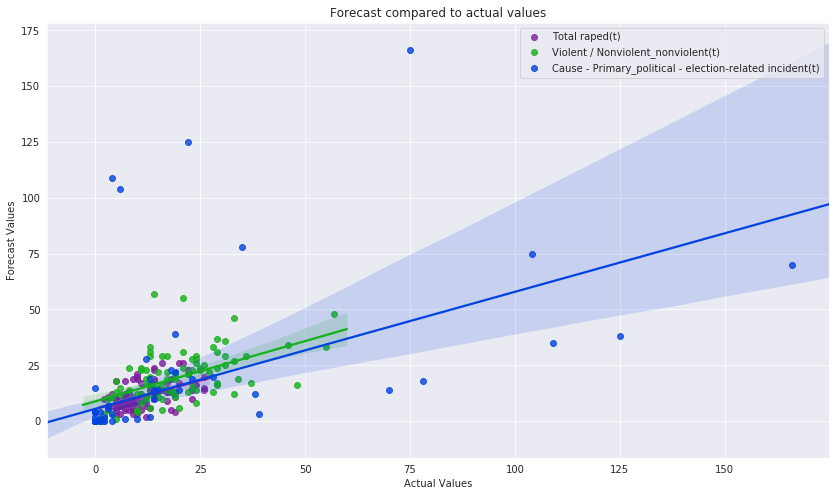

scores  \
                                                         r_2   
Collective / Interpersonal_collective(t)            0.298183   
Actor 1 - Youth/non-youth_unknown(t)                0.297541   
Actor 2 - Youth/non-youth_na(t)                     0.275117   
Actor 2 - Target_political organization/politic...  0.274377   
Cause - Primary_political - election-related in...  0.271079   
Violent / Nonviolent_nonviolent(t)                  0.245456   
Total raped(t)                                      0.229793   
Female raped(t)                                     0.211277   
Youth raped(t)                                      0.194675   
Onesided / Twosided_onesided(t)                      0.17015   

                                                                       \
                                                   explained_variance   
Collective / Interpersonal_collective(t)                     0.298556   
Actor 1 - Youth/non-youth_unknown(t)                         0.301158   
Actor 2 - Youth/non-youth_na(t)                               0.27647   
Actor 2 - Target_political organization/politic...           0.277422   
Cause - Primary_political - election-related in...           0.277207   
Violent / Nonviolent_nonviolent(t)                           0.276912   
Total raped(t)                                               0.318343   
Female raped(t)                                              0.292871   
Youth raped(t)                                               0.268727   
Onesided / Twosided_onesided(t)                               0.17631   

                                                                            \
                                                   root_mean_squared_error   
Collective / Interpersonal_collective(t)                           23.2056   
Actor 1 - Youth/non-youth_unknown(t)                               19.8244   
Actor 2 - Youth/non-youth_na(t)                                    15.3459   
Actor 2 - Target_political organization/politic...                 1.92892   
Cause - Primary_political - election-related in...                 24.0173   
Violent / Nonviolent_nonviolent(t)                                  9.6337   
Total raped(t)                                                     5.11425   
Female raped(t)                                                    4.99031   
Youth raped(t)                                                     4.45274   
Onesided / Twosided_onesided(t)                                    16.2158   

                                                   control_scores  \
                                                              r_2   
Collective / Interpersonal_collective(t)               -0.0166692   
Actor 1 - Youth/non-youth_unknown(t)                   -0.0422835   
Actor 2 - Youth/non-youth_na(t)                          0.043861   
Actor 2 - Target_political organization/politic...       0.148997   
Cause - Primary_political - election-related in...      0.0477848   
Violent / Nonviolent_nonviolent(t)                      0.0941051   
Total raped(t)                                          0.0199168   
Female raped(t)                                         0.0245817   
Youth raped(t)                                          -0.142222   
Onesided / Twosided_onesided(t)                         -0.170813   

                                                                       \
                                                   explained_variance   
Collective / Interpersonal_collective(t)                    -0.016533   
Actor 1 - Youth/non-youth_unknown(t)                       -0.0420202   
Actor 2 - Youth/non-youth_na(t)                             0.0440733   
Actor 2 - Target_political organization/politic...           0.148997   
Cause - Primary_political - election-related in...          0.0477848   
Violent / Nonviolent_nonviolent(t)                          0.0947098   
Total raped(t)                                            

In [35]:
#call find var again, using params from above.  
model = RandomForestRegressor(random_state=56, **best_params)
    
print("Finding Variables...")
scores, top = find_var(X_week, y_week, model, n_true=20, verbose=2, s_plot=4, n_plot=7)
    #print top 10 scores that beat control
top[:10]

### Comparatively Evaluate Predictive Models

In [38]:
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import TheilSenRegressor



def search_models(modellist, catlist, verbose=False, random_state=False):
    categories = y_week.columns.tolist()
    scoresdf = pd.DataFrame(index=categories)
    warnings.filterwarnings("ignore")
    for model in modellist:
        #par = model.get_params
        modelstring = str(model)[:13]
        print('\n{}:'.format(modelstring))
        try:
            print('Trying Native Multioutput...')
            _, model_scoresdf = find_var(X_week, y_week[catlist], model, n_true=10, verbose=verbose, random_state=random_state)
        except:
            print('Failed... Using MultiOutput wrapper')
            _, model_scoresdf = find_var(X_week, y_week[catlist], MultiOutputRegressor(model, n_jobs=-1), n_true=10, verbose=verbose, random_state=random_state)
        
        print('Top 3 scores:\n',model_scoresdf[('scores','explained_variance')].sort_values(ascending=False)[:3])
        
        
        
        scoresdf = scoresdf.join(model_scoresdf, how='left', sort=False, rsuffix=('_'+modelstring))
        #top5 = scoresdf.sort_values(scoresdf.columns.tolist(), axis=0, ascending=False)[:5]
        #top5_col = top5.sort_values(top5.index.tolist(), axis=1, ascending=False).iloc[:,:1]
        #print(top5_col)
        
        #label first section of df < debug later
        if scoresdf.shape[1] == 3:
            new_cols = scoresdf.columns.tolist()
            for x in range(3):
                new_cols[x] = new_cols[x] + '_' + modelstring
            scoresdf.columns = new_cols
            print('appended', modelstring, 'to first column name')
    
    print('Bing!')
    return scoresdf

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)
    random_state=56
    modellist=[RandomForestRegressor(random_state=random_state,**best_params),
               LinearRegression(),
               MLPRegressor(random_state=random_state),
               #ARDRegression(), <throws a big error
               BayesianRidge(),
               ElasticNet(random_state=random_state),
               #ElasticNetCV(random_state=random_state), < save automatic Cv for holdout sets
               #HuberRegressor(),
               #Lars(random_state=random_state), < tiny results
               Lasso(random_state=random_state),
               #MultiTaskLassoCV(random_state=random_state),<way too slow
               PassiveAggressiveRegressor(random_state=random_state),
               #Perceptron(random_state=random_state),
               TheilSenRegressor(random_state=random_state)]
               #RidgeCV()]
    
    scoresdf = search_models(modellist, top.index, random_state=random_state)
    scoresdf.head()


RandomForestR:
Trying Native Multioutput...
Top 3 scores:
 Total raped(t)                               0.32031
Actor 1 - Youth/non-youth_unknown(t)        0.306378
Collective / Interpersonal_collective(t)    0.300368
Name: (scores, explained_variance), dtype: object

LinearRegress:
Trying Native Multioutput...
Top 3 scores:
 Event Form - Secondary_violent - abduction(t)                                                 -0.223731
Cause - Primary_political - other political issues(t)                                         -0.349423
Cause - Primary_mob justice - extra-judicial response on basis of witchcraft allegations(t)   -0.368196
Name: (scores, explained_variance), dtype: object

MLPRegressor(:
Trying Native Multioutput...
Top 3 scores:
 Weapons_improvised explosive device (t)    0.300051
Actor 2 - Target_group of civilians (t)    0.218269
Actor 1 - Youth/non-youth_na(t)            0.152176
Name: (scores, explained_variance), dtype: object

BayesianRidge:
Trying Native Multioutput..

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
scoresdf.head()

In [ ]:
#top_scores_df = scoresdf.sort_values(scoresdf.columns.tolist(), axis=0, ascending=False).iloc[:10,:]
#top_scores_df.dropna(inplace=True)

#Plot explained variance of scores of various regressors
colr=0
expv = scoresdf.iloc[:,1::3].dropna()
expv = expv.sort_values(expv.columns[0])
f, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_xlim(-1,1)
for col in expv.columns:
    #plot = expv.loc[expv[col] > 0]
    if len(expv) > 0:
        sns.barplot(x=col, y=expv.index, data=expv, color=catpal[colr*2], label=col[-13:], alpha=0.7, ax=ax, dodge=True)
    colr+=1
#sns.barplot(y=expv.index, data=expv, alpha=0.5, ax=ax)    
plt.xlabel('explained variance score')
plt.ylabel('output category')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
        
#for col in scoresdf.columns[2::3]:
    #plot = scoresdf[[col]].sort_values(col).loc[scoresdf[col] < .3]
    #if len(plot) > 0:
        #sns.barplot(x=col, y=plot.index, data=plot)
        #plt.show()
expv.head()

In [ ]:
def interpret_coefs(coefs, X_train, cats):
    '''plot histograms of the coefficients as well and bar charts of the top coefficients'''
    
    #plot histogram of coefficents for each out variable  
    for cat in range(len(cats)):
        try:
            sns.distplot(coefs[cat], color=catpal[cat], label=cats[cat])#.sort_values(1))
        except:
            print("couldn't plot ", cats[cat])
    try: 
        sns.distplot(coefs)
    except:
        pass
    
    #plot top coefficnts for each variable - currently doesn't do it, plotting top for one. 
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    #creat a dataframe of coefiecents and their feature labels by output
    print(coefs.shape)
    if coefs.shape[0] > 1:
        coefframe = pd.DataFrame(coefs, index=X_train.columns)
    else:
        coefframe = pd.DataFrame(coefs, columns=cats, index=X_train.columns)
        
    #coefframe = coefframe.transpose()
    
    try:
        serieslist = []
        for cat in coefframe.columns:
            serieslist.append(coefframe.loc[:,cat].nlargest(20))
            data = concat(serieslist, axis=1)
    except:
        data=coefframe.nlargest(20)
    n=0
    for cat in coefframe.columns: 
        sns.swarmplot(y=data.index, x=cat, data=data, color=catpal[n], alpha=.5)
        n += 1
        
        #plt.legend()
    plt.ylabel('input category')
    plt.xlabel('coef / importance')
    plt.legend()
    plt.show()
    #except:
     #   print("Couldn't plot the top coefs for reasons")

def investigate(cats, X_train, y_train, holdout_X, holdout_y, model, verbose=0, random_state=None):
    '''function to look futher into better performing results'''
    holdout_scores = pd.DataFrame(index=cats, columns=['r_2', 'explained_variance','root_mean_squared_error'])
    #for cat in cats:
    y = y_train[cats]# > y_train[cat].quantile(.5)
    if verbose > 0:
        #print('\n',y_train[cats].columns,':')
        r_2, ev, rmse, coefs = try_model(X_train, y, model, verbose = 2, random_state=random_state)
        interpret_coefs(coefs,X_train,cats)
    
    #h_y = holdout_y[cats]# > holdout_y[cat].quantile(.5)
    #y_pred, model = test_model(X_train, holdout_X, y, model)
    #train_score, test_score, r_2, ev, rmse, coefs = score_model(X_train, holdout_X, y, h_y, y_pred, model)
    #if verbose > 0:
        #plot_model(holdout_X, h_y, y_pred)
        #interpret_coefs(coefs, holdout_X, cats)
        #scores = score_model(X_train, holdout_X, y, h_y, y_pred, model)
        #holdout_scores.loc[cat,['train_score', 'test_score', 'confusion_matrix', 'r_2']] = scores
        #holdout_scores.loc[cat,'train_score'] = train_score
        #holdout_scores.loc[cat,'test_score'] = test_score
        #holdout_scores.loc[cat,'confusion_matrix'] = cm
    #holdout_scores.loc[cats,'r_2'] = r_2
    #holdout_scores.loc[cats,'explained_variance'] = ev
    #holdout_scores.loc[cats,'root_mean_squared_error'] = rmse
    #return holdout_scores


In [ ]:
tops = scoresdf['explained_variance_RandomForestR'].sort_values(ascending=False)[:5]
tops

In [ ]:
if __name__ == '__main__': #protect windows from parallel processes(if you run windows)            
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    model = RandomForestRegressor()
    holdout = investigate(tops.index, X_week, y_week, holdout_X_week, holdout_y_week, model, verbose=True, random_state=38)
#holdout.sort_values('explained_variance', ascending=False)

In [ ]:
#create function to optimize lookback!
import random
from sklearn.linear_model import MultiTaskElasticNetCV

def opt_lookback(df, model):
    '''function to optimize number of units to look back through time'''
    print('Optimizing...')
    scorelist = []
    categories = df.columns.tolist()
    scoredf = pd.DataFrame(index=categories)#need to
    
    #generate a random state for consistent comparisons
    random_state = random.randint(1,1000)
    print('using random_state:', random_state)
    #loop through possible ranges to look back at to find the the optimum value
   
    for lookback in (range(1,50)):
        
        #create a timeshifted dataframe within that range
        time_shift = make_timeshift(df, lookback)
        
        #split timeshift into training and hold out data sets
        X, y, holdout_X, holdout_y = create_X_y(time_shift)
        
        #bandaid fix
        scoredf.index = y.columns.tolist()
        
        #find the scores for all the variables #(those which have more positives than negatives)
        scores = find_var(X, y, model, n_true=20, verbose=0, random_state=random_state)
        
        #print(scores.head())
        #find the sum of the crossvalidation scores
        #test = np.sum(scores['cv_mean'])
        
        
        #find which variables recieved a score above 0
        top_scores = scores.loc[scores['explained_variance'] > 0].index.tolist()
        #print(top_scores)
        
        #find sum of scores above 0
        top_sum = np.sum(scores.loc[top_scores,'explained_variance'])
        
        #use investigate function to see how those variables did against the holdout set
        #holdout_scores = investigate(top_scores, X, y, holdout_X, holdout_y, model, verbose=False, random_state=random_state)             
        #print(holdout_scores.head())
        
        #find the sum of the hold out test scores scores
        #holdout_max = np.max(holdout_scores.loc[:,'explained_variance'])
        #print(holdout_sum)
        
        #print the lookback interval, and mean scores
        #print('\nt-{0} top sum: {1:.2f}, holdout_max: {2:.2f} '.format(lookback,top_sum, holdout_max))
        print('\nt-{0} top sum: {1:.2f},'.format(lookback,top_sum))
        
        #append the crossvalidation score to the list
        scorelist.append(top_sum)#,cv_score)
        
        #join the scores to the data frame of scores
        scoredf = scoredf.join(scores, how='left', sort=False, rsuffix=('(t-'+str(lookback).zfill(3)+')'))
        #scoredf = scoredf.join(holdout_scores, how='left', sort=False, rsuffix='_holdout(t-'+str(lookback).zfill(3)+')')
        #scoredf = pd.concat([scoredf, scores, holdout_scores], axis=1, join_axes=[scoredf.index])
        
        #stop fuction and return scores soon as there is a definate downward trend
        if len(scorelist) > 10:
            if np.median(scorelist[-2:]) < np.median(scorelist[-5:-2]):
                return scoredf

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)            
    
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    model = RandomForestRegressor(random_state=56)
    #scoredf_day = opt_lookback(in_day, model)
    scoredf_week = opt_lookback(in_week, model)
    print('bing!')

    scoredf_week.head()
    #plt.plot(scoredf_day)#, label = 'by day')
    #plt.plot(scoredf_week, label = 'by week')
    #plt.title('Mean crossvalidation scores v. lookback times')
    #plt.legend()
    #plt.show()

In [ ]:
scoredf_week
#scoredf_week['cv_mean'].sum()
#scoredf_week.iloc[:,::4]

In [ ]:
def plot_frame(df, start):
    plotframe = df.iloc[:,start::3]#.sort_values(df.columns[start::4].tolist(), axis=0, ascending=False)[:10]
    meanlist = pd.Series([plotframe.loc[x,:].mean() for x in plotframe.index], index=plotframe.index)
    plotvar = plotframe.loc[meanlist.sort_values(ascending=False)[:10].index]
    #sortvar = plotvar.sort_index(axis=1, ascending=False)
    for label in plotvar.index:
        plt.plot(plotvar.loc[label,:], label=label)

    plt.xticks(rotation=90)
    #plt.ylim(-1,1)
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Top 10 '+plotvar.columns[0])
    plt.show()
    #print(plotvar)

#print('day')
#for start in [0,1,3,5,7]:
    #plot_frame(scoredf_day, start)

print('week')
for start in [0,1,2]:
    plot_frame(scoredf_week, start)
    


The appears to be a sweet spot around 6. There is a peak in the r_2 / ev sums and a dip in rmse. Let's see what that looks like.

In [ ]:
#create a timeshifted dataframe within that range
time_shift_try = make_timeshift(in_week, 6)
        
#split timeshift into training and hold out data sets
X, y, holdout_X, holdout_y = create_X_y(time_shift_try)
        
model = RandomForestRegressor(random_state=56)
    
scores = find_var(X, y, model, n_true=20, verbose=2)
top = scores.loc[scores['explained_variance'] > .2].sort_values('explained_variance', ascending=False)

In [ ]:
top

In [ ]:
investigate(top.iloc[[10],:].index, X, y, holdout_X, holdout_y, model, verbose=True)

In [ ]:
#next is to grid search parameters for tuning... don't forget crossvalidation. it's needed for the outliers
#also sliding window....
#put in a "control" that just uses the previous weeks score. 
